Esta versión contiene las bases para entrenar modelos sin utilizar la función .fit la cual presenta leak de memoria.

Se basa en las funciones que ya se encuentran presentes en la libreria

Este notebook corresponde al caso en donde no comparamos pixeles de imagenes mientra se entrena, si no que es un approach completamente parametrico.

El modelo si bien es capaz de generar las imagenes si se agrega una función extra de post-procesamiento

In [1]:
# !rm -r grav_lensing
# !pip uninstall grav_lens

In [2]:
!git clone https://github.com/fbientrigo/grav_lensing

Cloning into 'grav_lensing'...
remote: Enumerating objects: 1035, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 1035 (delta 36), reused 80 (delta 25), pack-reused 940 (from 1)
Receiving objects: 100% (1035/1035), 532.53 MiB | 57.71 MiB/s, done.
Resolving deltas: 100% (456/456), done.
Updating files: 100% (255/255), done.


In [3]:
!pip install /content/grav_lensing/src/ -qq

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 94.1 MB/s eta 0:00:00


In [4]:
import os
os.makedirs('/content/data', exist_ok=True)
!cd data && wget https://descargas.inf.santiago.usm.cl/train/2.tar.gz .

--2024-10-02 17:25:34--  https://descargas.inf.santiago.usm.cl/train/2.tar.gz
Resolving descargas.inf.santiago.usm.cl (descargas.inf.santiago.usm.cl)... 200.1.22.243
Connecting to descargas.inf.santiago.usm.cl (descargas.inf.santiago.usm.cl)|200.1.22.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8243980907 (7.7G) [application/octet-stream]
Saving to: ‘2.tar.gz’

2.tar.gz            100%[===================>]   7.68G  9.86MB/s    in 22m 58s 

2024-10-02 17:48:33 (5.71 MB/s) - ‘2.tar.gz’ saved [8243980907/8243980907]

--2024-10-02 17:48:33--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2024-10-02 17:48:33--
Total wall clock time: 22m 59s
Downloaded: 1 files, 7.7G in 22m 58s (5.71 MB/s)


In [5]:
!tar -xf /content/data/2.tar.gz -C /content/data/

In [ ]:
!ls /content/data/2

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import grav_lens.preprocess as gp
from grav_lens.utils.statistics import get_stats
from grav_lens.preprocess.filtering import process_batch_filters

from grav_lens.models.load_models import load_minmaxscaler, load_ipca_low
# Cargar el MinMaxScaler
minmaxscaler = load_minmaxscaler()
print(minmaxscaler)
# Cargar el modelo IPCA low
ipca_low = load_ipca_low()
print(ipca_low)



IncrementalPCA(batch_size=64, n_components=64)


In [ ]:
from grav_lens import get_datasets
max_files = -1
batch_size = 64
home_data = "/content/data"

train_dataset, val_dataset, test_dataset = get_datasets(
    data_index=2,
    max_files=max_files,
    home=home_data,
    batch_size=batch_size,
    val_split=0.2,
    test_split=0.1,
)

for X_batch, y_batch in train_dataset.take(1):
    print(X_batch.shape)
    print(y_batch.shape)

# Training

### Inicialización

In [ ]:
N_GAUSS = 40

In [10]:
def preprocess_ybatch(y_batch, corte=2):
    low_batch, high_batch = process_batch_filters(y_batch)

    # se agregaron tecnicas de regularización
    gaussians = gp.gmm_batch_vectors(high_batch, n_gaussians_positive=N_GAUSS, n_gaussians_negative=0,
                                    threshold=corte, n_points=750, scale=0.75, density_threshold=0.01)

    low_freq_stack = np.vstack([img.reshape(-1, 128*128) for img in low_batch]) #stack para el pca
    principal_components = ipca_low.transform(low_freq_stack)
    return [principal_components, gaussians]



for X_batch, y_batch in train_dataset.take(1):
    y_batch = minmaxscaler.transform(y_batch) # [0, 1] #escalar los datos

    print(X_batch.shape)
    print(y_batch.shape)

    y_process = preprocess_ybatch(y_batch)
    print(y_process[0].shape)
    print(y_process[1].shape)

(64, 128, 128, 3)
(64, 128, 128, 1)
(64, 64)
(64, 40, 5)


## Funcioens de TRaining

In [38]:
import tensorflow as tf
import numpy as np
import time

# callbacks
def prepare_callbacks(callbacks, model):
    if callbacks:
        for callback in callbacks:
            callback.set_model(model)
            callback.on_train_begin()
    return callbacks

def run_callbacks_on_epoch_end(callbacks, epoch, logs):
    if callbacks:
        for callback in callbacks:
            callback.on_epoch_end(epoch, logs=logs)

def run_callbacks_on_train_end(callbacks):
    if callbacks:
        for callback in callbacks:
            callback.on_train_end()



# Función para inicializar el optimizador con un scheduler
def get_optimizer_with_scheduler(optimizer_name='sgd', initial_lr=0.001, scheduler=None, momentum=0.0, nesterov=False):
    """
    Inicializa el optimizador con un scheduler opcional.

    Parámetros:
        optimizer_name (str): Nombre del optimizador a utilizar ('adam' o 'sgd').
        initial_lr (float): Learning rate inicial.
        scheduler (tf.keras.optimizers.schedules, opcional): Scheduler para ajustar el learning rate durante el entrenamiento.
        momentum (float, opcional): Momento para el optimizador SGD (por defecto 0.0).
        nesterov (bool, opcional): Si usar Nesterov momentum para SGD (por defecto False).

    Retorna:
        tf.keras.optimizers.Optimizer: Optimizador inicializado.
    """
    # Si se proporciona un scheduler, usarlo como learning rate
    lr = scheduler if scheduler else initial_lr

    if optimizer_name.lower() == 'adam':
        return tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer_name.lower() == 'sgd':
        return tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=nesterov)
    else:
        raise ValueError("Optimizer not recognized. Please use 'adam' or 'sgd'.")
# ------


# ..... regularización
import tensorflow as tf

def std_regularization_loss(std_x, std_y, lambda_reg=0.5):
    """
    Calcula una pérdida de regularización que incentiva la diversidad de las desviaciones estándar.

    Parámetros:
        std_x (tf.Tensor): Tensor de desviaciones estándar `x`.
        std_y (tf.Tensor): Tensor de desviaciones estándar `y`.
        lambda_reg (float): Factor de regularización que controla la magnitud de la penalización.

    Returns:
        tf.Tensor: Valor escalar de la pérdida de regularización.
    """
    # Calcular la media y la varianza de std_x y std_y
    # mean_std_x = tf.reduce_mean(std_x)
    # mean_std_y = tf.reduce_mean(std_y)

    var_std_x = tf.math.reduce_variance(std_x)
    var_std_y = tf.math.reduce_variance(std_y)

    # La pérdida de regularización busca aumentar la varianza y alejar los valores de la media
    reg_loss_x = tf.math.maximum(0.0, 1.0 - var_std_x)  # Penaliza poca varianza
    reg_loss_y = tf.math.maximum(0.0, 1.0 - var_std_y)

    # Sumar las pérdidas de regularización para std_x y std_y
    reg_loss = lambda_reg * (reg_loss_x + reg_loss_y)

    return reg_loss

import tensorflow as tf

def mean_regularization_loss(mean_x, mean_y, alpha_reg=0.5, beta_reg=0.01, target_mean=64.0):
    """
    Calcula una pérdida de regularización que incentiva la diversidad de las medias.

    Parámetros:
        mean_x (tf.Tensor): Tensor de medias `x`.
        mean_y (tf.Tensor): Tensor de medias `y`.
        alpha_reg (float): Factor de regularización que controla la penalización de la dispersión.
        beta_reg (float): Factor de regularización que controla la penalización respecto al objetivo `target_mean`.
        target_mean (float): Valor objetivo para las medias (por defecto 64.0, la mitad de 128).

    Returns:
        tf.Tensor: Valor escalar de la pérdida de regularización.
    """

    # Calcular la media de las medias
    mean_mean_x = tf.reduce_mean(mean_x)
    mean_mean_y = tf.reduce_mean(mean_y)

    # Penalizar la cercanía de las medias al objetivo `target_mean`
    mean_deviation_x = -tf.abs(mean_mean_x - target_mean)
    mean_deviation_y = -tf.abs(mean_mean_y - target_mean)

    # Penalizar la falta de varianza
    var_m_x = tf.math.reduce_variance(mean_x)
    var_m_y = tf.math.reduce_variance(mean_y)
    reg_loss_var_x = tf.math.maximum(0.0, 1.0 - var_m_x)  # Penaliza poca varianza
    reg_loss_var_y = tf.math.maximum(0.0, 1.0 - var_m_y)

    # Sumar las pérdidas de regularización para incentivar diversidad y alejarse del target_mean
    reg_loss = alpha_reg * (reg_loss_var_x + reg_loss_var_y) - beta_reg * (mean_deviation_x + mean_deviation_y)

    return reg_loss





#------

# Definir un scheduler personalizado (opcional)
def cosine_scheduler(epoch, lr):
    max_epochs = 30
    return lr * (tf.math.cos(epoch * np.pi / max_epochs) + 1) / 2

# Función para calcular la pérdida y las métricas (solo MSE en este caso)
def calculate_losses(y_true, y_pred, mse_fn):
    mse_loss = mse_fn(y_true, y_pred)
    return mse_loss

# Función para ejecutar el entrenamiento de una época
def train_epoch(model, train_dataset, optimizer, mse_fn, print_steps,
                mean_regularization={'alpha_reg': 20, 'beta_reg': 40, 'target_mean': 64.0},
                std_regularization={'lambda_reg': 2}):

    train_mse_metric = tf.keras.metrics.Mean(name='train_mse')
    lr_metric = tf.keras.metrics.Mean(name='learning_rate')

    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        # Preprocesar y_batch
        principal_components, gaussians = preprocess_ybatch(y_batch_train)

        with tf.GradientTape() as tape:
            # El modelo debe devolver las dos ramas: lowfreq y highfreq
            lowfreq_pred, highfreq_pred = model(x_batch_train, training=True)

            # Calcular pérdidas separadas para ambas ramas
            mse_loss_low = mse_fn(principal_components, lowfreq_pred)
            mse_loss_high = mse_fn(gaussians, highfreq_pred)

            # Extraer los valores de mean_x y mean_y
            mean_x_pred = highfreq_pred[..., 0]
            mean_y_pred = highfreq_pred[..., 1]

            # Extraer los valores de std_x y std_y
            std_x_pred = highfreq_pred[..., 2]
            std_y_pred = highfreq_pred[..., 3]

            # Calcular la pérdida de regularización para las desviaciones estándar
            # Utiliza el diccionario de std_regularization
            reg_loss_std = std_regularization_loss(std_x_pred, std_y_pred,
                                                   lambda_reg=std_regularization.get('lambda_reg', 0.5))

            # Calcular la pérdida de regularización para las medias
            # Utiliza el diccionario de mean_regularization
            reg_loss_mean = mean_regularization_loss(
                mean_x_pred, mean_y_pred,
                alpha_reg=mean_regularization.get('alpha_reg', 0.5),
                beta_reg=mean_regularization.get('beta_reg', 0.01),
                target_mean=mean_regularization.get('target_mean', 64.0))

            # Sumar las pérdidas de regularización
            reg_loss = reg_loss_std + reg_loss_mean

            # Sumar las pérdidas
            total_loss =10* mse_loss_low + mse_loss_high + reg_loss

        # Aplicar gradientes
        grads = tape.gradient(total_loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Actualizar la métrica MSE
        train_mse_metric(total_loss)

        # Capturar el learning rate actual y actualizar la métrica
        lr_metric(optimizer.learning_rate.numpy() if isinstance(optimizer.learning_rate, tf.Tensor) else optimizer.learning_rate)

        # Mostrar progreso
        if step % print_steps == 0:
            print(f'Step {step}: Total MSE = {train_mse_metric.result().numpy():.3f}, \tLowFreq MSE = {mse_loss_low.numpy():.3f}, \tHighFreq MSE = {mse_loss_high.numpy():.3f}, \tReg Loss = {reg_loss.numpy():.3f}, \tLR = {lr_metric.result().numpy():.3e}')

    return train_mse_metric.result().numpy(), lr_metric.result().numpy()


# Función para ejecutar la validación
def validate_epoch(model, val_dataset, mse_fn):
    val_mse_metric = tf.keras.metrics.Mean(name='val_mse')

    for val_x, val_y in val_dataset:

        principal_components, gaussians = preprocess_ybatch(val_y)
        lowfreq_pred, highfreq_pred = model(val_x, training=False)

        mse_loss_low = mse_fn(principal_components, lowfreq_pred)
        mse_loss_high = mse_fn(gaussians, highfreq_pred)
        total_loss = mse_loss_low + mse_loss_high

        val_mse_metric(total_loss)

    return val_mse_metric.result().numpy()

# Función para reiniciar métricas
def reset_metrics(metric):
    metric.reset_state()


# Más sobre metricas
import grav_lens.metrics as metrics
import matplotlib.pyplot as plt

def validate_epoch_with_metrics(model, val_dataset, mse_fn, num_samples_to_take=15):
    val_mse_metric = tf.keras.metrics.Mean(name='val_mse')

    val_sample = val_dataset.shuffle(buffer_size=50).take(num_samples_to_take)

    for val_x, val_y in val_sample:
        # Preprocesar y_batch
        principal_components, gaussians = preprocess_ybatch(val_y)

        # El modelo debe devolver las dos ramas: lowfreq y highfreq
        lowfreq_pred, highfreq_pred = model(val_x, training=False)

        # Calcular pérdidas separadas para ambas ramas
        mse_loss_low = mse_fn(principal_components, lowfreq_pred)
        mse_loss_high = mse_fn(gaussians, highfreq_pred)

        # Calcular la pérdida de regularización para las desviaciones estándar
        std_x_pred = highfreq_pred[:,:,:, 2]  # std_x valores predichos
        std_y_pred = highfreq_pred[:,:,:, 3]  # std_y valores predichos
        reg_loss = std_regularization_loss(std_x_pred, std_y_pred)

        # Sumar las pérdidas
        total_loss = mse_loss_low + mse_loss_high  + reg_loss

        # Actualizar la métrica MSE
        val_mse_metric(total_loss)

    return val_mse_metric.result().numpy() #, wmape_metric.result().numpy(), dice_metric.result().numpy() #, dpeaks_metric.result().numpy()

def train_model_with_metrics(epochs, model, train_dataset, val_dataset, optimizer, mse_fn, print_steps, callbacks=None, subset_size=100):
    # Inicializar las métricas
    train_mse_metric = tf.keras.metrics.Mean(name='train_mse')
    val_mse_metric = tf.keras.metrics.Mean(name='val_mse')

    history = {
        'loss': [], 'val_loss': [], 'learning_rate': []
    }

    # Preparar callbacks
    callbacks = prepare_callbacks(callbacks, model)

    # Iterar sobre las épocas
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        # Toma un subset de los datos
        subset_dataset = train_dataset.shuffle(buffer_size=300).take(subset_size)

        # Entrenar una época

        train_loss, train_lr = train_epoch(model, subset_dataset, optimizer, mse_fn, print_steps)
        history['loss'].append(train_loss)
        history['learning_rate'].append(train_lr)


        # Validación con métricas adicionales
        val_loss = validate_epoch_with_metrics(model, val_dataset, mse_fn) #, wmape_val, dice_val
        history['val_loss'].append(val_loss)

        logs = {
            'loss': train_loss, 'val_loss': val_loss, 'learning_rate': train_lr
        }

        run_callbacks_on_epoch_end(callbacks, epoch, logs)

        # Resetear métricas

        reset_metrics(train_mse_metric)
        reset_metrics(val_mse_metric)

    # Ejecutar callbacks al final del entrenamiento
    print("end training callbacks")
    run_callbacks_on_train_end(callbacks)

    return history

def plot_extended_training_history(history):
    """
    Visualiza la historia de entrenamiento y validación, incluyendo learning rate y métricas adicionales.

    Parámetros:
        history (dict): Diccionario con 'loss', 'val_loss', 'learning_rate'
    """
    epochs = range(1, len(history['loss']) + 1)

    # Crear figura con subplots
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Gráfico de las pérdidas
    ax1.plot(epochs, history['loss'], 'b-', label='Training Loss')
    ax1.plot(epochs, history['val_loss'], 'orange', label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training & Validation Loss')
    ax1.legend(loc='upper left')

    # Crear un segundo eje para el learning rate
    ax2 = ax1.twinx()
    ax2.plot(epochs, history['learning_rate'], 'gray', label='Learning Rate', linestyle='--')
    ax2.set_ylabel('Learning Rate')
    ax2.legend(loc='upper right')

    plt.show()



### Creacion del modelo

In [39]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Bloque convolucional estándar con BatchNormalization y ReLU
def conv_block(x, filters, kernel_size=(3, 3), padding='same', use_batchnorm=True):
    x = layers.Conv2D(filters, kernel_size, padding=padding, kernel_initializer='he_normal')(x)
    if use_batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

# Bloque residual
def residual_block(x, filters, activation='relu', use_batchnorm=True):
    shortcut = x  # Conexión residual

    # Primer bloque convolucional
    x = conv_block(x, filters, kernel_size=(3, 3), use_batchnorm=use_batchnorm)

    # Segundo bloque convolucional
    x = layers.Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    if use_batchnorm:
        x = layers.BatchNormalization()(x)

    # Adaptar el número de canales del atajo (shortcut) si es necesario
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), padding='same', kernel_initializer='he_normal')(shortcut)

    # Agregar la conexión residual y activar
    x = layers.Add()([x, shortcut])
    x = layers.Activation(activation)(x)
    return x

# Bloque convolucional denso
def dense_block(x, units, dropout_rate=0.05, activation='relu',use_batchnorm=True):
    x = layers.Dense(units, kernel_initializer='he_normal')(x)
    if use_batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Dropout(dropout_rate)(x)
    return x


In [54]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Clase personalizada para recortar los canales
class TrimChannels(layers.Layer):
    def call(self, inputs):
        return inputs[:, :, :, :2]
    def get_config(self):
        config = super().get_config()
        return config

# Clase personalizada para escalar las coordenadas mean_x_y
class ScaleMeanXY(layers.Layer):
    def call(self, inputs):
        return (128 / 2) * (inputs + 1)
    def get_config(self):
        config = super().get_config()
        return config

# Clase personalizada para escalar std_x_y
class ScaleStdXY(layers.Layer):
    def call(self, inputs):
        return inputs * 5 + 1e-6
    def get_config(self):
        config = super().get_config()
        return config

# Función para construir el modelo CNN con bloques modulares
def create_complex_cnn_model(input_shape=(128, 128, 3), n_gaussians=40, dropout_rate=0.05):
    input_img = layers.Input(shape=input_shape)
    trimmed_input = TrimChannels()(input_img)  # Seleccionar los primeros dos canales

    # Bloques convolucionales iniciales
    x = conv_block(trimmed_input, 16)
    # x = layers.MaxPooling2D(pool_size=(2, 2))(x)  # 64x64
    x = conv_block(x, 32)

    # Bloque convolucional con conexiones residuales
    x = conv_block(x, 64)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)  # 32x32

    # Rama de baja frecuencia (lowfreq) - predicción de PCA
    low_freq = conv_block(x, 64)
    low_freq = conv_block(low_freq, 128)
    low_freq = layers.Flatten()(low_freq)
    low_freq = dense_block(low_freq, 256, dropout_rate=dropout_rate)
    low_freq = layers.Dense(64, name='lowfreq_output')(low_freq)
    low_freq_output = layers.LeakyReLU(alpha=0.2)(low_freq)

    # Rama de alta frecuencia (highfreq) - predicción de gaussianas
    high_freq = conv_block(x, 64)
    high_freq = residual_block(high_freq, 64)
    high_freq = layers.MaxPooling2D(pool_size=(2, 2))(high_freq)  # 16x16
    high_freq = residual_block(high_freq, 64)
    high_freq = conv_block(high_freq, 128)
    high_freq = layers.Flatten()(high_freq)
    high_freq = dense_block(high_freq, 512, dropout_rate=2*dropout_rate)

    high_freq_output = layers.Dense(n_gaussians * 5, activation='linear', name='highfreq_output')(high_freq)
    high_freq_output = layers.Reshape((n_gaussians, 5))(high_freq_output)

    # Escalado de la salida de alta frecuencia
    mean_x_y = layers.Activation('tanh')(high_freq_output[:,:, :2])
    mean_x_y = ScaleMeanXY()(mean_x_y)

    std_x_y = layers.Activation('sigmoid')(high_freq_output[:,:, 2:4])
    std_x_y = ScaleStdXY()(std_x_y)

    weights = layers.Activation('relu')(high_freq_output[:,:, 4])
    high_freq_output_scaled = layers.Concatenate(axis=-1)([mean_x_y, std_x_y, weights[:,:, tf.newaxis]])

    # Modelo final con las dos ramas de salida
    model = models.Model(inputs=input_img, outputs=[low_freq_output, high_freq_output_scaled])

    return model


Aqui el uso de callbacks

In [17]:


# Early stopping callback basado en val_mse
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode="min",
    patience=5,  # Número de épocas sin mejora antes de detener
    restore_best_weights=True  # Restaurar los mejores pesos
)



callbacks = [
    early_stopping
]




In [55]:
cnn_model = create_complex_cnn_model()

In [20]:
# Definir el optimizador

scheduler = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=2000,  # Número de pasos antes de llegar a lr mínimo
    alpha=1e-2  # Valor final del learning rate (porcentaje del learning rate inicial)
)

optimizer = get_optimizer_with_scheduler('adam', 1e-3, scheduler, momentum=0.01, nesterov=True)

# Definir la función de pérdida MSE
mse_fn = tf.keras.losses.MeanSquaredError()

# Entrenar el modelo
# history = train_model(
#     epochs=5,                        # Número de épocas de entrenamiento
#     model=cnn_model,                  # Modelo CNN que has definido con dos ramas
#     train_dataset=train_dataset,      # Dataset de entrenamiento preprocesado
#     val_dataset=val_dataset,          # Dataset de validación preprocesado
#     optimizer=optimizer,              # Optimizador con el scheduler
#     mse_fn=mse_fn,                    # Función de pérdida (MSE)
#     print_steps=25,                   # Mostrar progreso cada 10 steps
#     callbacks=callbacks               # Callbacks, incluyendo EarlyStopping y TimeStopping
# )
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)



history = train_model_with_metrics(
    epochs=10,
    model=cnn_model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    optimizer=optimizer,
    mse_fn=mse_fn,
    print_steps=10,
    callbacks=callbacks,
    subset_size=50  # subset es el número de datos por época
)


Epoch 1/10
Step 0: Total MSE = 1176.245, 	LowFreq MSE = 3.135, 	HighFreq MSE = 999.313, 	Reg Loss = 145.583, 	LR = 1.000e-03
Step 10: Total MSE = 1183.421, 	LowFreq MSE = 2.838, 	HighFreq MSE = 998.867, 	Reg Loss = 197.092, 	LR = 1.000e-03
Step 20: Total MSE = 1152.548, 	LowFreq MSE = 2.633, 	HighFreq MSE = 959.394, 	Reg Loss = 23.231, 	LR = 9.999e-04
Step 30: Total MSE = 1114.823, 	LowFreq MSE = 2.386, 	HighFreq MSE = 934.995, 	Reg Loss = 32.595, 	LR = 9.998e-04
Step 40: Total MSE = 1092.272, 	LowFreq MSE = 2.304, 	HighFreq MSE = 952.362, 	Reg Loss = 105.111, 	LR = 9.997e-04
Epoch 2/10
Step 0: Total MSE = 936.076, 	LowFreq MSE = 2.183, 	HighFreq MSE = 903.106, 	Reg Loss = 11.139, 	LR = 9.985e-04
Step 10: Total MSE = 905.788, 	LowFreq MSE = 2.146, 	HighFreq MSE = 799.277, 	Reg Loss = 39.420, 	LR = 9.981e-04
Step 20: Total MSE = 875.227, 	LowFreq MSE = 2.245, 	HighFreq MSE = 734.526, 	Reg Loss = 179.092, 	LR = 9.978e-04
Step 30: Total MSE = 853.335, 	LowFreq MSE = 2.307, 	HighFreq MSE =

In [ ]:
# prev_history2 = history

In [ ]:
# for key in history:
#     if key in prev_history:
#         prev_history2[key].extend(history[key])
#     else:
#         prev_history2[key] = history[key]


# historial

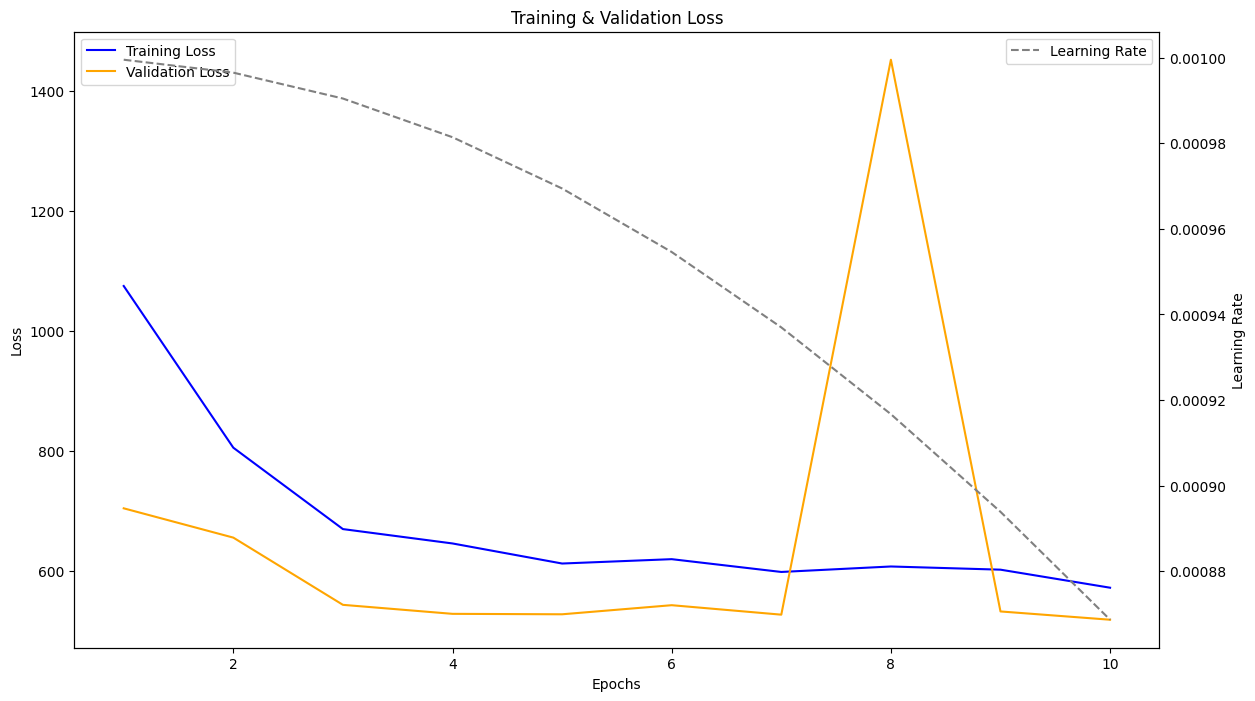

In [21]:
plot_extended_training_history(history)

### reconstruccion

2/2 [==============================] - 0s 65ms/step


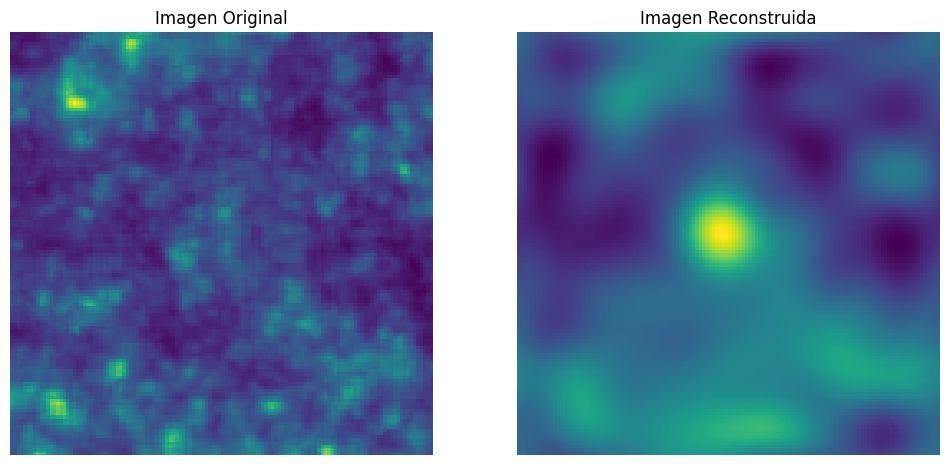

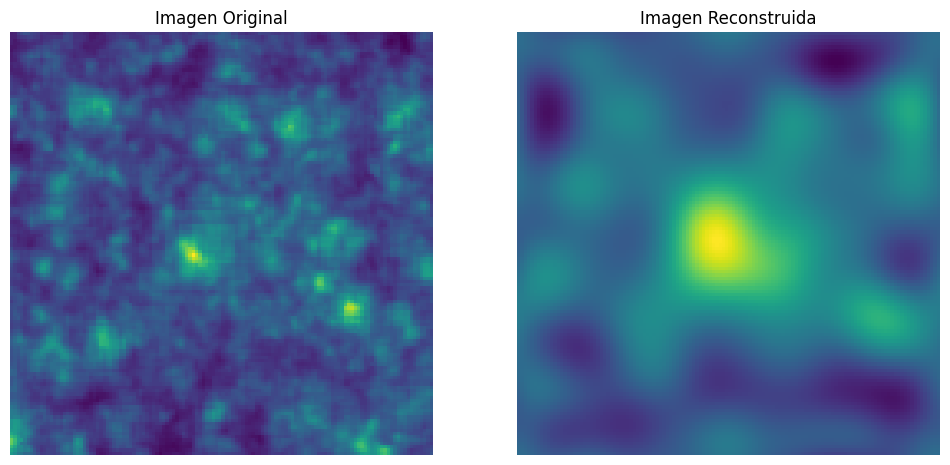

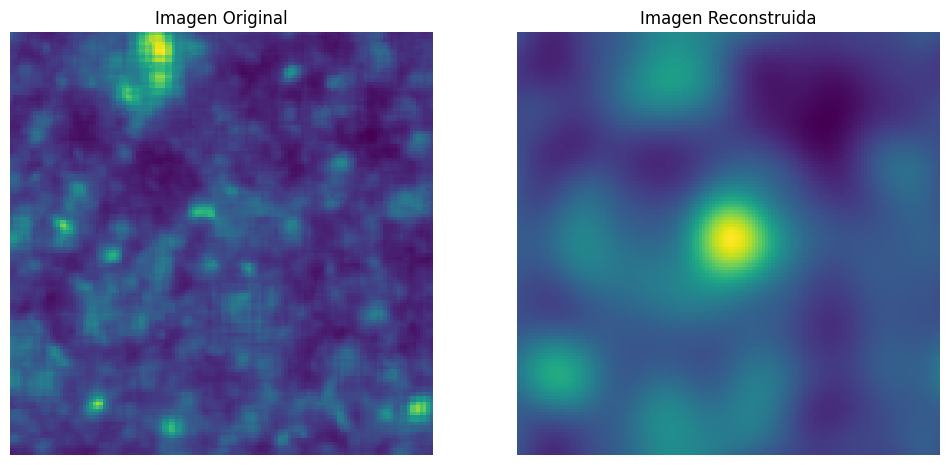

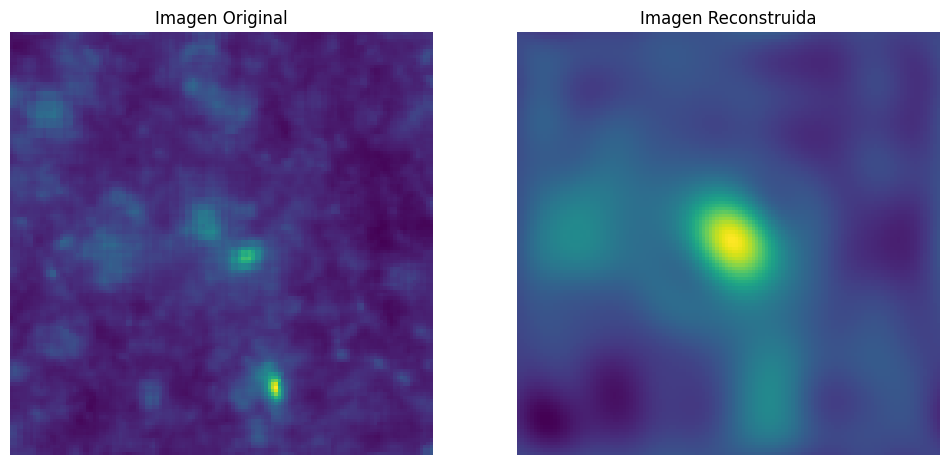

In [22]:
from grav_lens.preprocess.gmm import reconstruct_image_from_gmm, reconstruct_lowfreq_from_pca, reconstruct_highfreq_from_gmm, reconstruct_batch_images, plot_comparison

for X_batch, y_batch in train_dataset.take(1):
    y_batch = minmaxscaler.transform(y_batch) # [0, 1] #escalar los datos


    low_batch, high_batch = process_batch_filters(y_batch)

    predictions = cnn_model.predict(X_batch)
    # Obtener el tamaño del batch
    batch_size = X_batch.shape[0]
    # Reconstruir imágenes de baja y alta frecuencia
    reconstructed_images = reconstruct_batch_images(*predictions, batch_size, ipca_low)

    # para comparar
    real_gaussians = gp.gmm_batch_vectors(high_batch, 40, 0, 1)

# graficar
for i in range(4):
    plot_comparison(y_batch[i,:,:,0],reconstructed_images[i,:,:,0])




Guardar el modelo

In [24]:
cnn_model.save_weights("model_1002_5pm_weights.h5")

In [23]:
cnn_model.save("model_1002_5pm.keras")

TypeError: Cannot serialize object Ellipsis of type <class 'ellipsis'>. To be serializable, a class must implement the `get_config()` method.

In [28]:
for layer in cnn_model.layers:
    print(layer.get_config())

{'batch_input_shape': (None, 128, 128, 3), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_3'}
{'name': 'lambda_2', 'trainable': True, 'dtype': 'float32', 'function': ('4wEAAAAAAAAAAAAAAAEAAAAEAAAAUwAAAHMQAAAAfABkAWQAZAKFAmYCGQBTACkDTi7pAgAAAKkA\nqQHaAXhyAgAAAHICAAAA+h88aXB5dGhvbi1pbnB1dC0xOS01NGRhYmUxNzUzM2U+2gg8bGFtYmRh\nPgQAAABzAgAAABAA\n', None, None), 'function_type': 'lambda', 'module': '__main__', 'output_shape': None, 'output_shape_type': 'raw', 'output_shape_module': None, 'arguments': {}}
{'name': 'conv2d_11', 'trainable': True, 'dtype': 'float32', 'filters': 16, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 're

# Histograma de Valores

In [25]:

import numpy as np

def gaussians_histogram(predictions_example):
    # Suponiendo que `predictions[1]` es la salida de las gaussianas con la forma (64, 40, 5)
    # Crear un histograma para cada componente
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    component_names = ['mean_x', 'mean_y', 'std_x', 'std_y', 'weight']

    for i in range(5):
        axes[i].hist(predictions_example[:, :, i].flatten(), bins=50, alpha=0.7, color='blue')
        axes[i].set_title(f'Histogram of {component_names[i]}')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

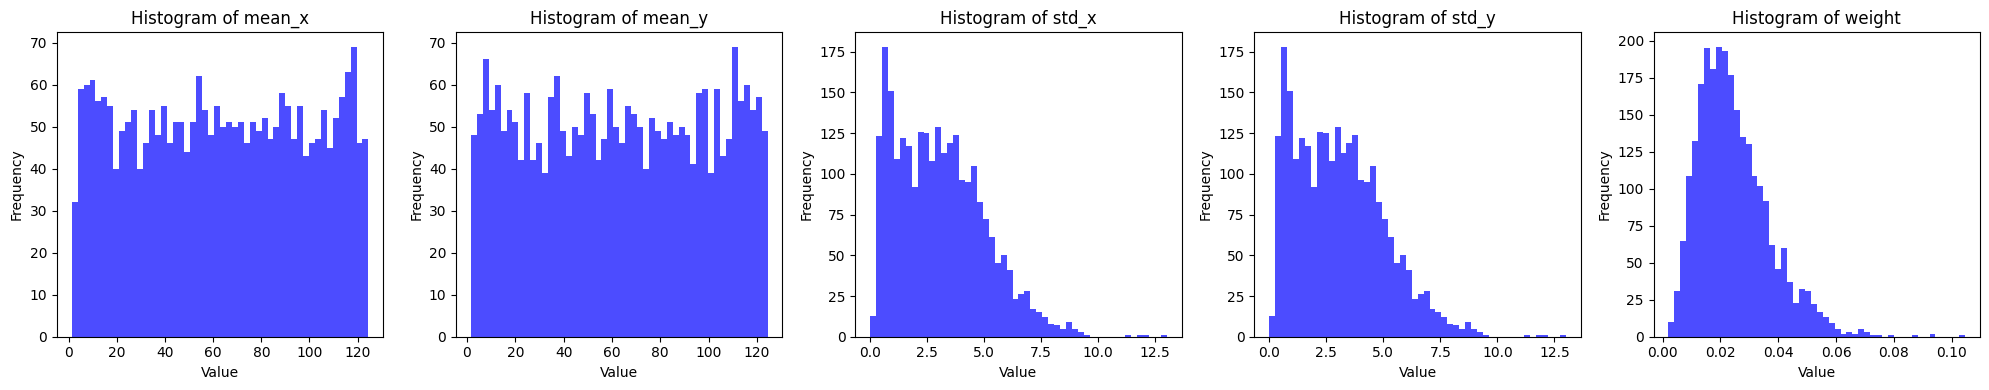

In [26]:
# datos reales
gaussians_histogram(predictions_example = real_gaussians)

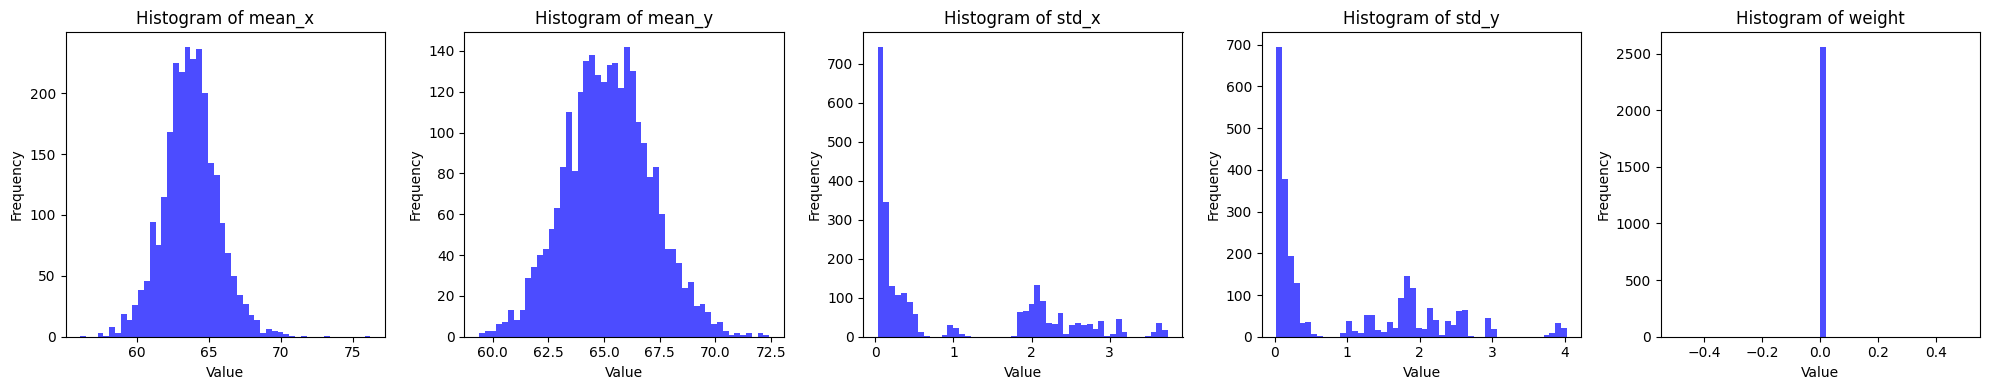

In [27]:
# predichos
gaussians_histogram(predictions_example = predictions[1])